# Primerjava analitike in numerike #

In [1]:
import lvm_read
import numpy  as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams.update({'text.usetex': True,
                     'font.size': 31,
                     'font.family':'lmodern',})

## ROC statika ##

In [2]:
class MeritevStatike():
    ''' Take a .lvm file for analysis of ROC. '''
    def __init__(self, read_data):
        self.data = lvm_read.read(read_data)
    
    def sig(self):
        '''Returns signal[0] and signal length[1] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        return sig, N

    def time(self):
        '''Returns dt[0], fs[1] and total time[2] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        dt = self.data[0]['Delta_X'][0]
        fs = 1 / dt
        cajt = dt * np.arange(N)
        return dt, fs, cajt
    
    def instruments(self):
        '''
        Returns instrument data of measurment Class:
        0 - Sila
        1 - Pomik
        '''
        # Sila
        force = self.data[0]['data'][:,0]
        # Pomik
        displacement = self.data[0]['data'][:,1]
        
        return force, displacement

### Analitika ###

In [3]:
## Parametri
E = 2400 #MPa
t1 = 0.5 #mm
t2 = 0.25 #mm
h = 10*t2 #mm
b = 4 #mm
I1 = b*t1**3 / 12 #mm^4
I2 = b*t2**3 / 12 #mm^4
l1 = 13 #mm
l2 = 20.37 #mm

# Analitične vrednosti togosti posameznih območij (Mathematica)
kp = 20.372*E*I1/l1**3
kn1 = 9250*E*I2/l2**3
kn2 = -1253.18*E*I2/l2**3
kn3 = 10571.42*E*I2/l2**3

#### Analitika (full ROC) ####

In [4]:
# celotne togosti in pomiki ROC
k1 = kp+1/2*kn1
k2 = kp+1/2*kn2
k3 = kp+1/2*kn3
dzg = 2*0.16*h
dsr = 2*1.33*h
dsp = 2*1.92*h
dk = 2*1.99*h
# skupne sile
F1 = k1*(dzg-0)
F2 = F1 + k2*(dsp-dzg)
F3 = F2 + k3*(dk-dsp)
# pozitivne sile
Fp = kp*dk
# negativne sile
Fzg = 1/2*kn1*(dzg-0)
Fsp = Fzg + 1/2*kn2*(dsp-dzg)

#### Analitika (half ROC) ####

In [5]:
# celotne togosti in pomiki ROC
#k1 = 2*kp+kn1
#k2 = 2*kp+kn2
#k3 = 2*kp+kn3
#dzg = 0.16*h
#dsr = 1.33*h
#dsp = 1.92*h
#dk = 1.99*h
# skupne sile
#F1 = k1*(dzg-0)
#F2 = F1 + k2*(dsp-dzg)
#F3 = F2 + k3*(dk-dsp)
# pozitivne sile
#Fp = 2*kp*dk
# negativne sile
#Fzg = kn1*(dzg-0)
#Fsp = Fzg + kn2*(dsp-dzg)

### Numerika (Ansys) ###

In [6]:
# Sila iz Ansysa
ansys_filename = "Analiza/ver8/MKE/F(x)_half_edited.txt"
x_ansys_half = np.loadtxt(ansys_filename, dtype=float, usecols=3, skiprows=1)
x_ansys_half = np.insert(x_ansys_half, 0, 0)*2
F_ansys_half = np.loadtxt(ansys_filename, dtype=float, usecols=4, skiprows=1)
F_ansys_half = np.insert(F_ansys_half, 0, 0)

ansys_filename = "Analiza/ver8/MKE/F(x)_pos_edited.txt"
x_ansys_pos = np.loadtxt(ansys_filename, dtype=float, usecols=3, skiprows=1)
x_ansys_pos = np.insert(x_ansys_pos, 0, 0)*2
F_ansys_pos = np.loadtxt(ansys_filename, dtype=float, usecols=4, skiprows=1)
F_ansys_pos = np.insert(F_ansys_pos, 0, 0)

ansys_filename = "Analiza/ver8/MKE/F(x)_neg_edited.txt"
x_ansys_neg = np.loadtxt(ansys_filename, dtype=float, usecols=3, skiprows=1)
x_ansys_neg = np.insert(x_ansys_neg, 0, 0)*2
F_ansys_neg = np.loadtxt(ansys_filename, dtype=float, usecols=4, skiprows=1)
F_ansys_neg = np.insert(F_ansys_neg, 0, 0)

### Eksperiment ###

In [7]:
# Brez dT
data_1 = MeritevStatike('Analiza/ver8/ver8_slim_half_22.lvm')
data_2 = MeritevStatike('Analiza/ver8/ver8_neg_12.lvm')
data_3 = MeritevStatike('Analiza/ver8/ver8_pos_11.lvm')

shift = 1.1 #mm
pomik_1 = -data_1.instruments()[1][::10]*2-shift #mm
sila_1 = data_1.instruments()[0][::10] #N

shift = 0.5 #mm
pomik_2 = -data_2.instruments()[1][::10]*2-shift #mm
sila_2 = data_2.instruments()[0][::10] #N

shift = 0.1 #mm
pomik_3 = -data_3.instruments()[1][::10]*2-shift #mm
sila_3 = data_3.instruments()[0][::10] #N

### Izris ###

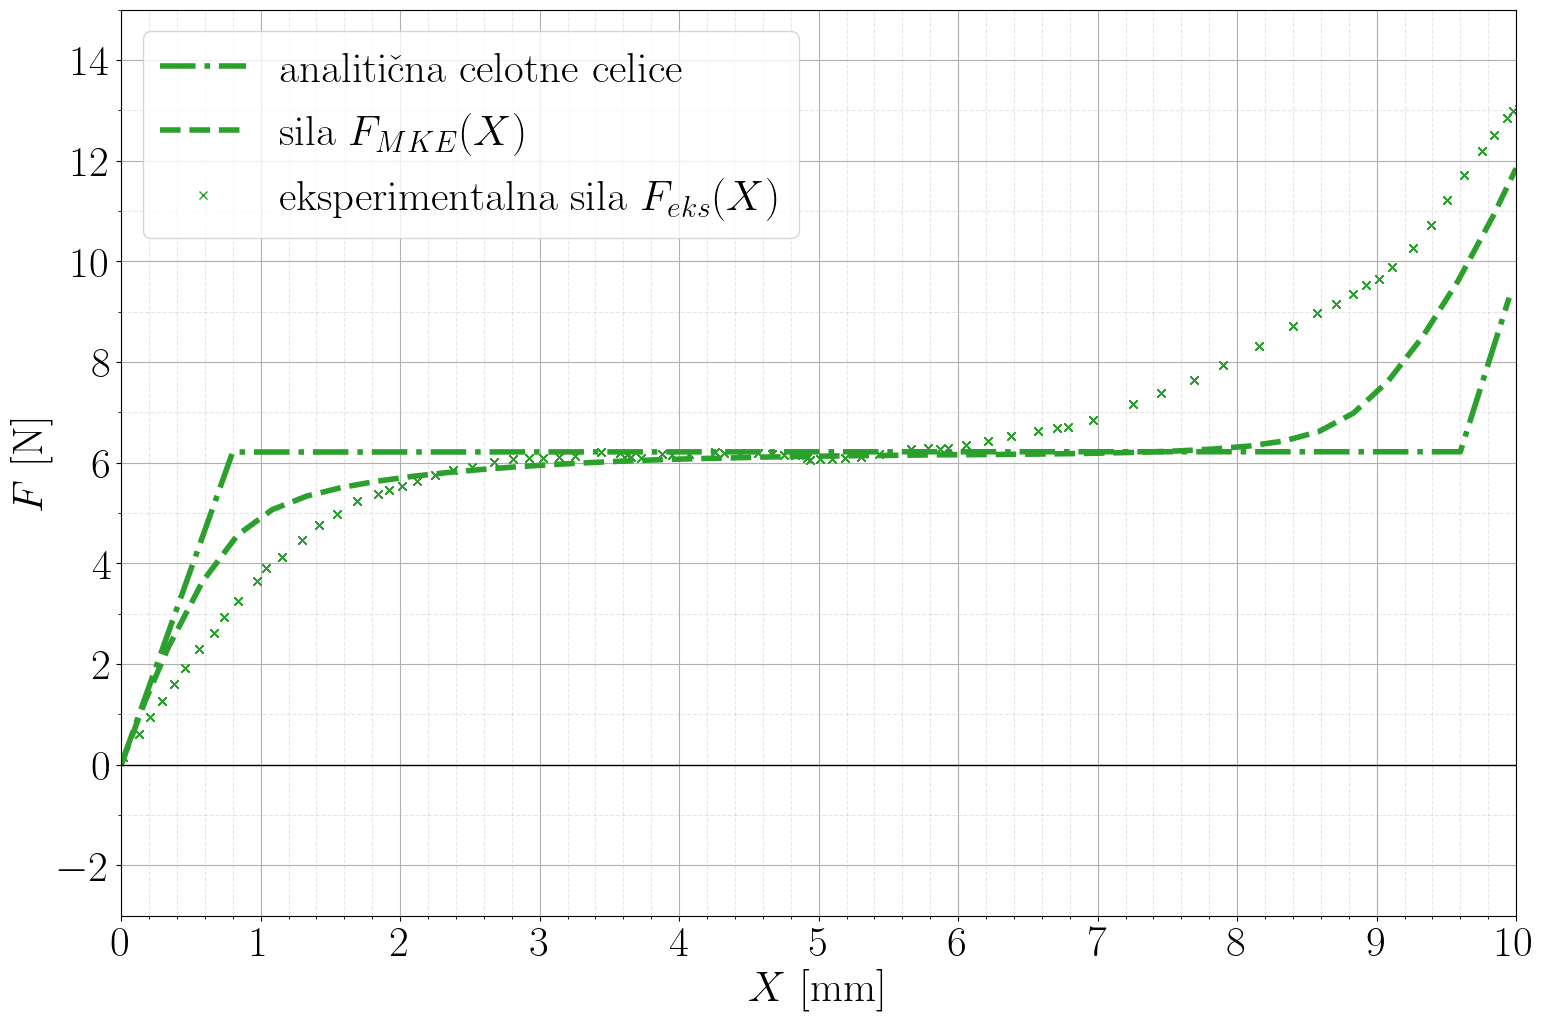

In [15]:
plt.rcParams['figure.figsize'] = [18, 12]

# Negativna sila
# plt.plot(np.array([0, dzg, dsr, dsp, dk]), [0,Fzg,0,Fsp,0], linestyle="-.", lw=1, color='tab:blue', label = r'negativna analitična sila')
# pozitivna sila
# plt.plot([0, dk], [0, Fp], linestyle="-.", lw=1, color='tab:red', label=r' analitična pozitivna sila')
# pozitivna sila za vmesni člen
# t1=0.75 #mm
# plt.plot([0, dk], [0, 20.372*E* (b*t1**3 / 12) /l1**3 * dk], linestyle="-.", lw=2, color='tab:orange', label=r'analitična pozitivna sila')
# skupna sila
plt.plot(np.array([0, dzg, dsr, dsp, dk]), np.array([0, F1, F2, F2, F3]), linestyle="-.", lw=4, color='tab:green', label= r'analitična celotne celice')

# Sila iz Ansysa
# plt.plot(x_ansys_neg, F_ansys_neg, linestyle="--", lw=2, color='tab:blue', label=r'numerična $F_{MKE}(X)$')
# plt.plot(x_ansys_pos, F_ansys_pos, linestyle="--", lw=2, color='tab:red', label=r'pozitivna numerična $F_{MKE}(X)$')
plt.plot(x_ansys_half, F_ansys_half, linestyle="--", lw=4, color='tab:green', label=r'sila $F_{MKE}(X)$')

# eksperimentalna sila
# plt.plot(pomik_2, sila_2, 'x', color='tab:blue', label=r'eksperimentalna sila $F_{eks}(X)$')
# plt.plot(pomik_3, sila_3, 'x', color='tab:red', label=r'eksperimentalna sila $F_{eks}(X)$')
plt.plot(pomik_1, sila_1, 'x', color='tab:green', label=r'eksperimentalna sila $F_{eks}(X)$')

plt.xlabel(r'$X$ [mm]')
plt.ylabel(r'$F$ [N]')
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)
plt.xlim(0, 10)
plt.ylim(-3, 15)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.savefig('sile_ROC.pdf', format='pdf')
plt.show()

## ROC statika pri spremembi T ##

In [12]:
class MeritevStatike_dT():
    ''' Take a .lvm file for analysis of ROC. '''
    def __init__(self, read_data):
        self.data = lvm_read.read(read_data)
    
    def sig(self):
        '''Returns signal[0] and signal length[1] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        return sig, N

    def time(self):
        '''Returns dt[0], fs[1] and total time[2] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        dt = self.data[0]['Delta_X'][0]
        fs = 1 / dt
        cajt = dt * np.arange(N)
        return dt, fs, cajt
    
    def instruments(self):
        '''
        Returns instrument data of measurment Class:
        0 - Silomer [N]
        1 - Pomik [mm]
        2 - Napetost segrevanja [V]
        3 - Tok segrevanja [mA]
        4 - Upornost [Ohm] 
        5 - Temperatura termočlena 
        '''

        # Sila
        force = self.data[0]['data'][:,0]
        # Pomik
        displacement = self.data[0]['data'][:,1]
        # Tok
        curr_in = self.data[0]['data'][:,3]
        curr = curr_in/1.1 *1000 #mA
        # Napetost
        volt_in = self.data[0]['data'][:,2]
        volt = volt_in/0.09007 - curr_in
        # Upornost 
        res = volt/(curr/1000)
        # Temperatura
        temp = self.data[0]['data'][:,4]
        
        return force, displacement, volt, curr, res, temp
    

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

### Analitika ( odvisnost E(dT) ) ###

In [13]:
## Parametri
Ep = 2400 #MPa
En = 1800 #MPa
t1 = 0.5 #mm
t2 = 0.25 #mm
h = 10*t2 #mm
b = 4 #mm
I1 = b*t1**3 / 12 #mm^4
I2 = b*t2**3 / 12 #mm^4
l1 = 13 #mm
l2 = 20.37 #mm

In [14]:
# Analitika
T_values = [22.0, 23.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0]
Ep = 2400 #MPa
En_values = [2400, 2378, 2355, 2318, 2280, 2240, 2200, 2140, 2080] #MPa

def F_analitika(Ep, En):
    # Analitične vrednosti togosti posameznih območij (Mathematica)
    kp = 20.372*Ep*I1/l1**3
    kn1 = 9250*En*I2/l2**3
    kn2 = -1253.18*En*I2/l2**3
    kn3 = 10571.42*En*I2/l2**3

    # celotne togosti in pomiki ROC
    k1 = kp+1/2*kn1
    k2 = kp+1/2*kn2
    k3 = kp+1/2*kn3
    dzg = 2*0.16*h
    dsr = 2*1.33*h
    dsp = 2*1.92*h
    dk = 2*1.99*h
    # skupne sile
    F1 = k1*(dzg-0)
    F2 = F1 + k2*(dsp-dzg)
    F3 = F2 + k3*(dk-dsp)
    # pozitivne sile
    Fp = kp*dk
    # negativne sile
    Fzg = 1/2*kn1*(dzg-0)
    Fsp = Fzg + 1/2*kn2*(dsp-dzg)
    
    d = np.array([dzg, dsr, dsp, dk])
    F = np.array([F1, F2, F3])
    
    return(d, F)

### Numerika (Ansys) ###

In [15]:
# Sila iz Ansysa
ansys_filename = ["Analiza/ver8_T/MKE/F(x)_T22.txt",
                  "Analiza/ver8_T/MKE/F(x)_T23.5.txt",
                  "Analiza/ver8_T/MKE/F(x)_T25.txt",
                  "Analiza/ver8_T/MKE/F(x)_T27.5.txt",
                  "Analiza/ver8_T/MKE/F(x)_T30.txt",
                  "Analiza/ver8_T/MKE/F(x)_T32.5.txt",
                  "Analiza/ver8_T/MKE/F(x)_T35.txt",
                  "Analiza/ver8_T/MKE/F(x)_T37.5.txt",
                  "Analiza/ver8_T/MKE/F(x)_T40.txt"]
x_ansys_half = np.zeros([len(ansys_filename),  len(np.loadtxt(ansys_filename[0], dtype=float, usecols=3, skiprows=1)) ])
F_ansys_half = np.zeros([len(ansys_filename),  len(np.loadtxt(ansys_filename[0], dtype=float, usecols=3, skiprows=1)) ])
for i in range(len(ansys_filename)):
    x_ansys_half_i = np.loadtxt(ansys_filename[i], dtype=float, usecols=3, skiprows=1)
    x_ansys_half[i] = x_ansys_half_i*2
    F_ansys_half_i = np.loadtxt(ansys_filename[i], dtype=float, usecols=4, skiprows=1)
    F_ansys_half[i] = F_ansys_half_i

### Eksperiment ###

In [16]:
# dT
data_1 = MeritevStatike_dT('Analiza/ver8_T/ver8_half_T21_11.lvm')
data_2 = MeritevStatike_dT('Analiza/ver8_T/ver8_half_T22_21.lvm')
data_3 = MeritevStatike_dT('Analiza/ver8_T/ver8_half_T25_11.lvm')
data_4 = MeritevStatike_dT('Analiza/ver8_T/ver8_half_T28_11.lvm')
data_5 = MeritevStatike_dT('Analiza/ver8_T/ver8_half_T32_11.lvm')

# Podatki
data_group = [data_1, data_2, data_3, data_4, data_5]
shift_i = [0.45, 0.90, 0.05 , 0.08, 0.17]

### Izris ###

0.0006045181754622442
0.009098900897831295
0.01797939192576244
0.03226539923156489
0.046937514842929434
0.06238184706541846
0.07782617928790769
0.10099267762164119
0.12415917595537498


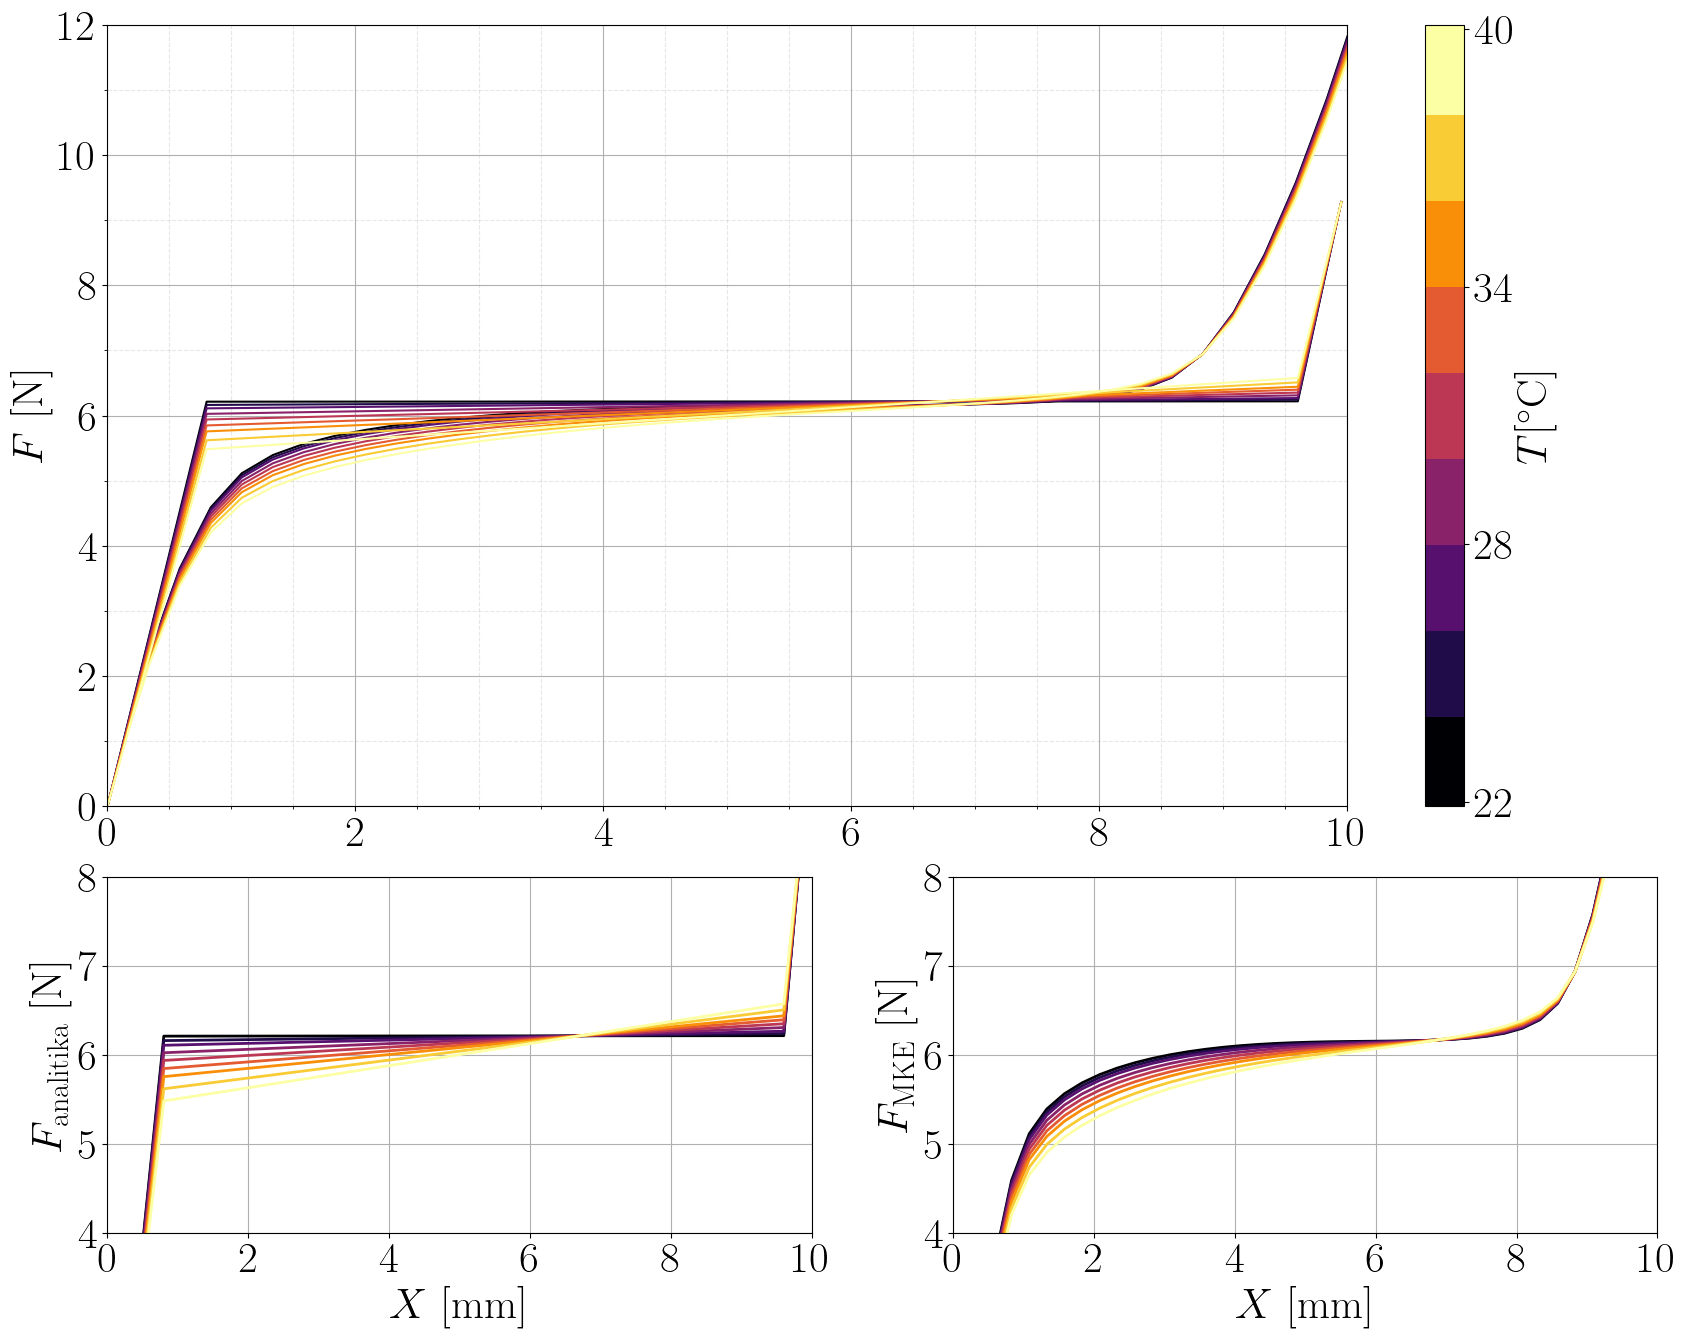

In [17]:
# Setup figure and subplots
fig = plt.figure(num = 0, figsize = (20, 16))#, dpi = 300)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (2, 1))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
axs=[ax1,ax2,ax3]

# Color bar
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(len(En_values)):
    # Analitična sila
    d = F_analitika(Ep, En_values[i])[0]
    F = F_analitika(Ep, En_values[i])[1]
    # izpis
    k_i = (F[1]-F[0])/(d[2]-d[0])
    print(k_i)
    axs[0].plot(np.array([0, d[0], d[2], d[3]]), np.array([0, F[0], F[1], F[2]]), 
             linestyle="-", lw=1.5, color=cmap(i), 
             label= r' $E_n (T=$'+ f' {T_values[i]}'+r'$^\circ$C)='+ f'{En_values[i]} MPa')
    axs[1].plot(np.array([0, d[0], d[2], d[3]]), np.array([0, F[0], F[1], F[2]]), 
             linestyle="-", lw=2, color=cmap(i), 
             label= r' $E_n (T=$'+ f' {T_values[i]}'+r'$^\circ$C)='+ f'{En_values[i]} MPa')
    # Sila iz Ansysa
    axs[0].plot(x_ansys_half[i], F_ansys_half[i], linestyle="-", lw=1.5, color=cmap(i))
    axs[2].plot(x_ansys_half[i], F_ansys_half[i], linestyle="-", lw=2, color=cmap(i))

#axs[0].set_xlabel(r'$X$ [mm]')
axs[0].set_ylabel(r'$F$ [N]')
axs[1].set_xlabel(r'$X$ [mm]')
axs[1].set_ylabel(r'$F_\mathrm{analitika}$ [N]')
axs[2].set_xlabel(r'$X$ [mm]')
axs[2].set_ylabel(r'$F_\mathrm{MKE}$ [N]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=10)
axs[0].set_xlim(0, 10)
axs[0].set_ylim(0, 12)
axs[1].set_xlim(0, 10)
axs[1].set_ylim(4, 8)
axs[2].set_xlim(0, 10)
axs[2].set_ylim(4, 8)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
axs[0].grid()
axs[0].grid(which='minor', linestyle = '--', alpha=0.3)
axs[1].grid()
axs[2].grid()
#axs[0].legend()

plt.colorbar(sm, ticks=np.linspace(22,T_values[-1],int(N/2)), 
             boundaries=np.arange(T_values[0]-0.1,T_values[-1]+0.1,.01)
            ).set_label(r'$T[^\circ$C]', labelpad=0.5, y=0.5, rotation=90)
plt.savefig('sile_ROC_temp.pdf', format='pdf')
plt.show()

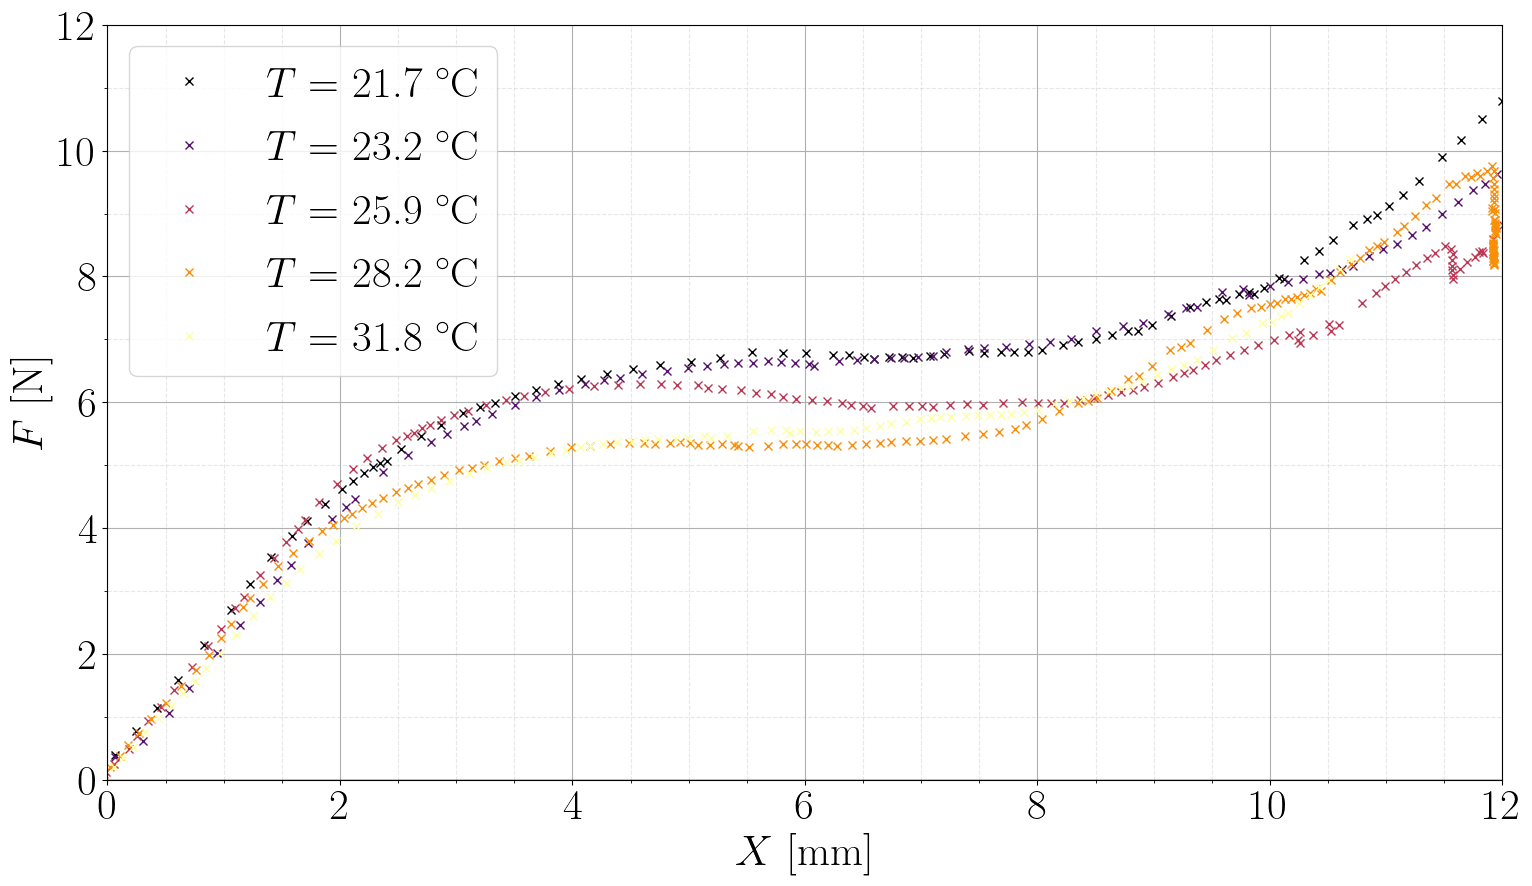

In [18]:
plt.rcParams['figure.figsize'] = [18, 10]

# Color bar
N = len(data_group)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(len(data_group)):
    # eksperimentalna sila
    pomik = -data_group[i].instruments()[1][::200]*2-shift_i[i] #mm
    sila = data_group[i].instruments()[0][::200] #N
    temp = np.round(np.mean(data_group[i].instruments()[5]), 1)
    plt.plot(pomik, sila, 'x', color=cmap(i), label = r'$T=$ ' + f'{temp} '+r'$^\circ$C')

plt.xlabel(r'$X$ [mm]')
plt.ylabel(r'$F$ [N]')
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=10)
plt.xlim(0, 12)
plt.ylim(0, 12)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.savefig('sile_ROC_temp_eksp.pdf', format='pdf')
plt.show()

## Disperzijske krivulja ##

In [100]:
# SPREMENLJIVKE
# amplitude A in B
AB = 0.0001
# mase
m = 0.44*10**(-6)# ton
M = 1.72*10**(-6) # ton
beta = m/M
# togosti
t3 = 0.75 #mm
l3 = 13 #mm
I3 = b*t3**3 / 12 #mm^4
K = 2*(20.372*Ep*I3/l3**3) # togost drugega elementa
k_i = np.array([
    0.0006045181754622442, 0.009098900897831295, 0.01797939192576244, 0.03226539923156489, 0.046937514842929434, 
    0.06238184706541846, 0.07782617928790769, 0.10099267762164119, 0.12415917595537498])

alpha_i = k_i/K
# dušenje
zeta = 0.01 #*np.sqrt(3*beta/(8*(1+beta)**3))
# lastne frekvence
omega_0 = np.sqrt(K/M)
kappa_i = np.sqrt(alpha_i/beta)

In [101]:
# aproksimacijska funkcija
gamma = 0.5
mu = 2*gamma/(gamma-1)

upsilon_i = k_i
delta_i = (1-upsilon_i) / (2*gamma**2*(1-gamma))
eta_i = -(3*(1-upsilon_i)) / (8*gamma**4*(1-gamma))
q_a = np.linspace(-0.4,0.4,100)
f_approx = lambda q, upsilon, delta, eta: upsilon*q + delta*q**3 + eta*q**5

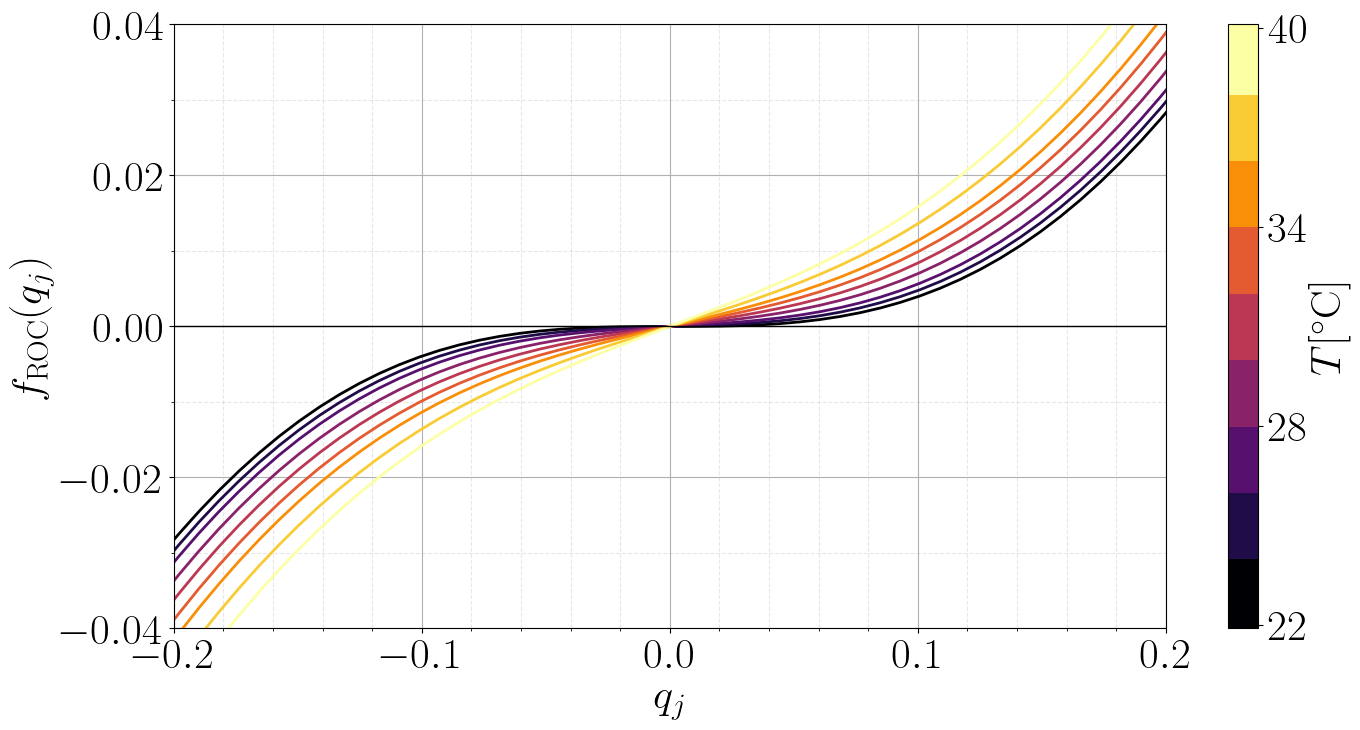

In [102]:
plt.rcParams['figure.figsize'] = [16, 8]


# Color bar
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(len(k_i)):
    plt.plot(q_a, f_approx(q_a, upsilon_i[i], delta_i[i], eta_i[i]), lw=2, color=cmap(i), 
             label= r' $E_n (T=$'+ f' {T_values[i]}'+r'$^\circ$C)='+ f'{En_values[i]} MPa')
    
plt.xlabel(r'$q_j$')
plt.ylabel(r'$f_\mathrm{ROC}(q_j)$')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=4)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlim(-0.2, 0.2)
plt.ylim(-0.04, 0.04)
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.axhline(0, color='black', lw=1)
#plt.legend()
plt.colorbar(sm, ticks=np.linspace(22,T_values[-1],int(N/2)), 
             boundaries=np.arange(T_values[0]-0.1,T_values[-1]+0.1,.01)
            ).set_label(r'$T[^\circ$C]', labelpad=0.5, y=0.5, rotation=90)
plt.savefig('Taylorjeva_funkcija.pdf', format='pdf')
plt.show()

In [103]:
# Disperzijska funkcija
f_a = np.linspace(0,200,6000)
omega_a = np.linspace(0,1,60000)

mu_u = lambda omega, kappa, alpha, upsilon, delta, eta, AB, zeta: np.arccos( 
        ( 2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon) + 4*1j*zeta*kappa*omega - (2+(alpha+kappa**2)*(AB*(3*delta+10*AB*eta)+upsilon))*omega**2 - 2*1j*(1+beta)*zeta*kappa*omega**3+omega**4 ) /
            (2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon)+4*1j*zeta*kappa*omega-2*omega**2)
        )

# lastne frekvence (kje morajo biti)
last_frek = np.sqrt(k_i[-1]/m)/(2*np.pi)
faktor = np.sqrt(omega_0/(2*np.pi))/(2*np.pi)
faktor_ups =  np.sqrt(k_i/m) / (2*np.pi) / np.sqrt(alpha_i*upsilon_i/beta)

### Disperzijska $\Delta T$ ###

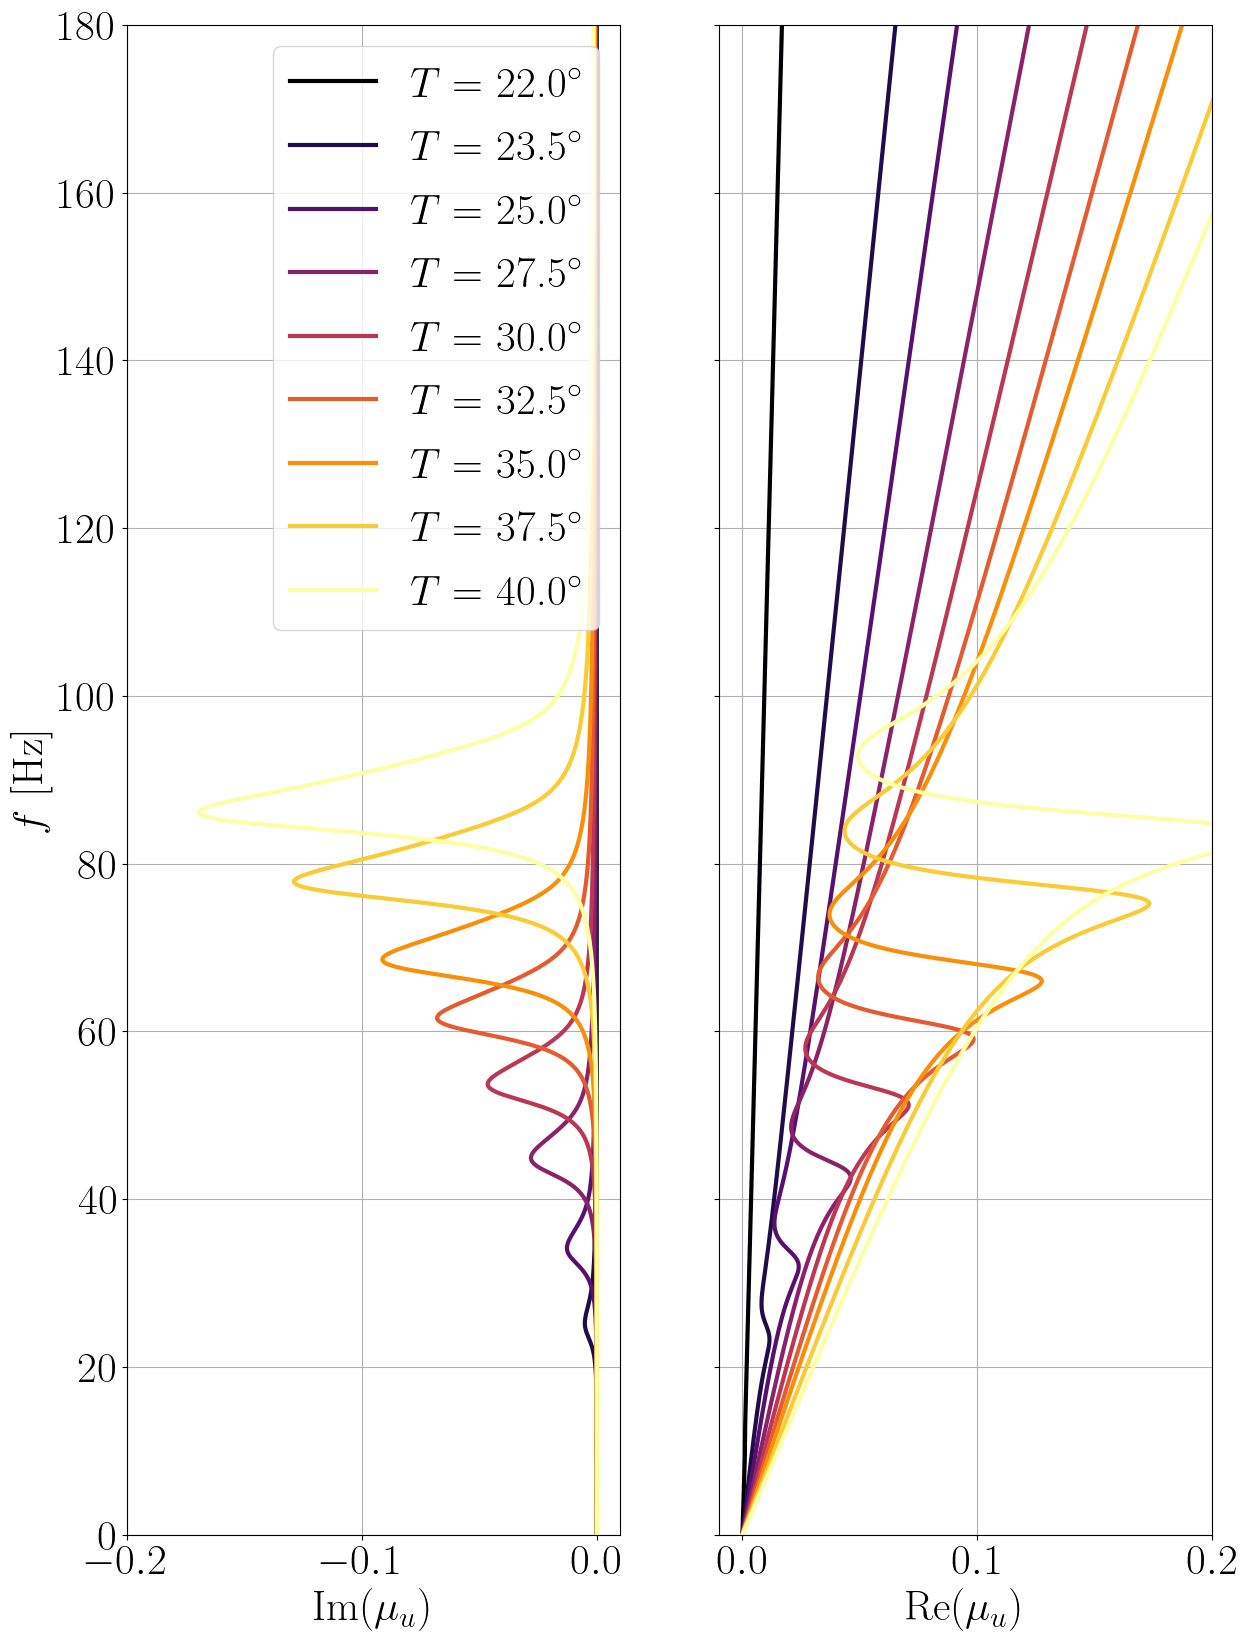

In [104]:
plt.rcParams['figure.figsize'] = [14, 20]


# Color map
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i in range(len(k_i)):
    # Imaginarna os
    ax1.plot(np.imag(mu_u(omega_a, kappa_i[i], alpha_i[i], upsilon_i[i], delta_i[i], eta_i[i], AB, zeta)), faktor_ups[i]*omega_a, 
             lw=3, color=cmap(i), label= r' $T=$'+ f' {T_values[i]}'+r'$^\circ$')
    
    # Realna os
    ax2.plot(np.real(mu_u(omega_a, kappa_i[i], alpha_i[i], upsilon_i[i], delta_i[i], eta_i[i], AB, zeta)), faktor_ups[i]*omega_a, 
             lw=3, color=cmap(i), label= r' $T=$'+ f' {T_values[i]}'+r'$^\circ$')    
    
ax1.set_xlabel(r'Im$(\mu_u)$')
ax1.set_ylabel(r'$f$ [Hz]')
ax1.locator_params(axis="x", nbins=3)
ax1.locator_params(axis="y", nbins=10)
ax1.set_xlim(-0.2, 0.01)
ax1.set_ylim(0, 180)
ax1.grid()
ax1.legend(loc= 'upper right')

ax2.set_xlabel(r'Re$(\mu_u)$')
ax2.locator_params(axis="x", nbins=3)
ax2.locator_params(axis="y", nbins=10)
ax2.set_xlim(-0.01, 0.2)
ax2.label_outer()
ax2.grid()

plt.savefig('FRF_disperzijska.pdf', format='pdf')
plt.show()

### Disperzijska sprememba AB ###

In [105]:
AB_i = AB*np.array([0.125/10, 0.125, 0.25, 0.5, 1, 2, 4, 7.1, 7.6, 8.0, 8.5, 8.8])*100
j = 3

print(alpha_i[j], upsilon_i[j], delta_i[j], eta_i[j])
print(AB_i)

0.006873349003521956 0.03226539923156489 3.8709384030737404 -11.612815209221221
[0.000125 0.00125  0.0025   0.005    0.01     0.02     0.04     0.071
 0.076    0.08     0.085    0.088   ]


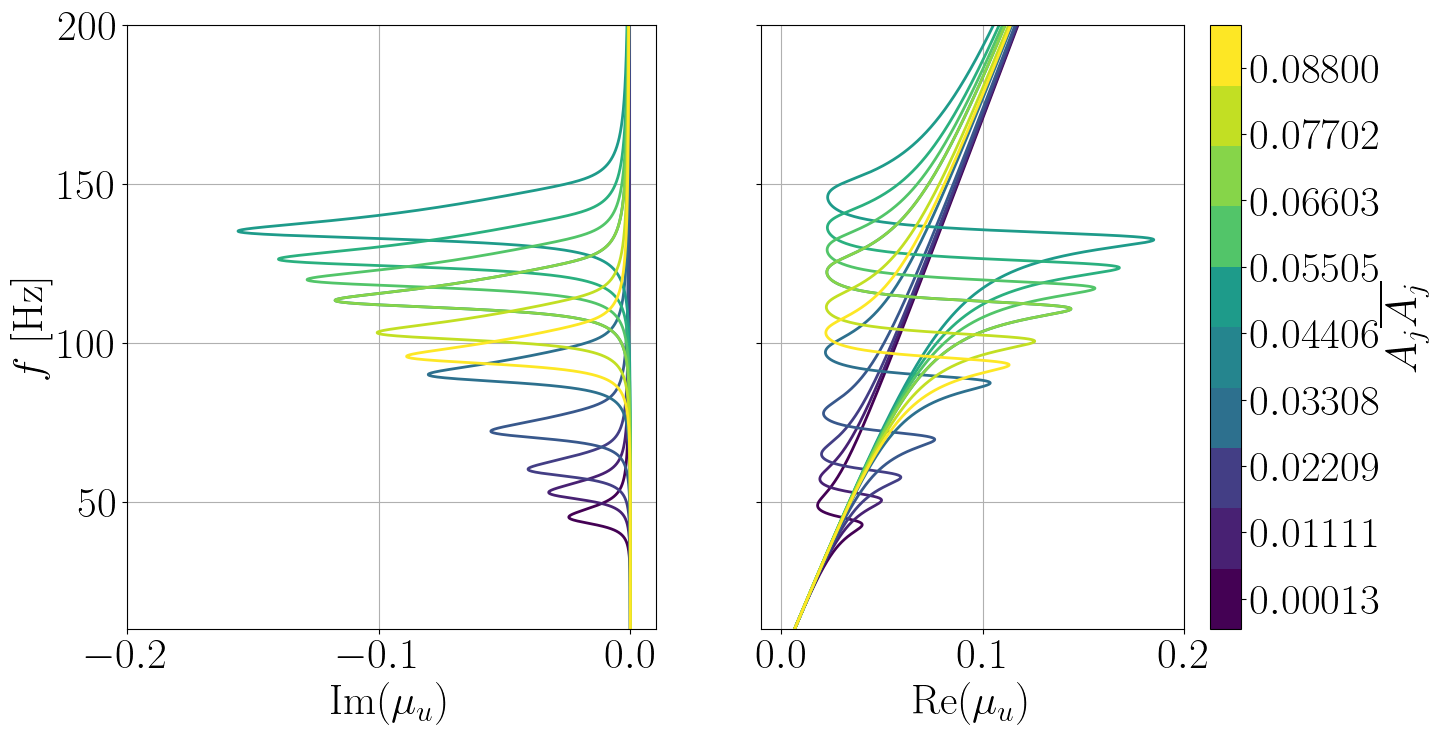

In [41]:
plt.rcParams['figure.figsize'] = [15, 8]

# Color map
N = len(AB_i)
cmap = plt.get_cmap('viridis',N)
norm = mpl.colors.Normalize(vmin=AB_i[0],vmax=AB_i[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i in range(len(AB_i)):
    #Imaginarna os
    ax1.plot(np.imag(mu_u(omega_a, kappa_i[j], alpha_i[j], upsilon_i[j], delta_i[j], eta_i[j], AB_i[i], zeta)), faktor_ups[j]*omega_a, 
             lw=2, color=cmap(i))
    
    #Realna os
    ax2.plot(np.real(mu_u(omega_a, kappa_i[j], alpha_i[j], upsilon_i[j], delta_i[j], eta_i[j], AB_i[i], zeta)), faktor_ups[j]*omega_a, 
             lw=2, color=cmap(i), label= r' $A_j \overline{A_j}=$'+ f' {np.round(AB_i[i],4)}')
    
    
ax1.set_xlabel(r'Im$(\mu_u)$')
ax1.set_ylabel(r'$f$ [Hz]')
ax1.locator_params(axis="x", nbins=4)
ax1.locator_params(axis="y", nbins=10)
#ax1.set_xlim(-0.2, 0)
ax1.set_ylim(10, 200)
ax1.set_xlim(-0.2, 0.01)
ax1.grid()

ax2.set_xlim(-0.01, 0.2)
ax2.set_xlabel(r'Re$(\mu_u)$')
ax2.locator_params(axis="x", nbins=4)
ax2.locator_params(axis="y", nbins=5)
ax2.label_outer()
#ax2.legend(loc= 'upper right')
plt.colorbar(sm, ticks=np.linspace( AB_i[0], AB_i[-1], 9), 
             boundaries=np.arange(AB_i[0]-0.005, AB_i[-1]+0.008,.01)
            ).set_label(r'$A_j \overline{A_j}$', labelpad=0.5, y=0.5, rotation=90)
ax2.grid()

plt.savefig('FRF_disperzijska_AB.pdf', format='pdf')
plt.show()

### Disperzijske sprememba dušenja ###

In [42]:
zeta_i = zeta*np.array([0.125, 0.25, 0.5, 1, 2, 4, 8])
print(zeta_i)
j = 3

[0.00125 0.0025  0.005   0.01    0.02    0.04    0.08   ]


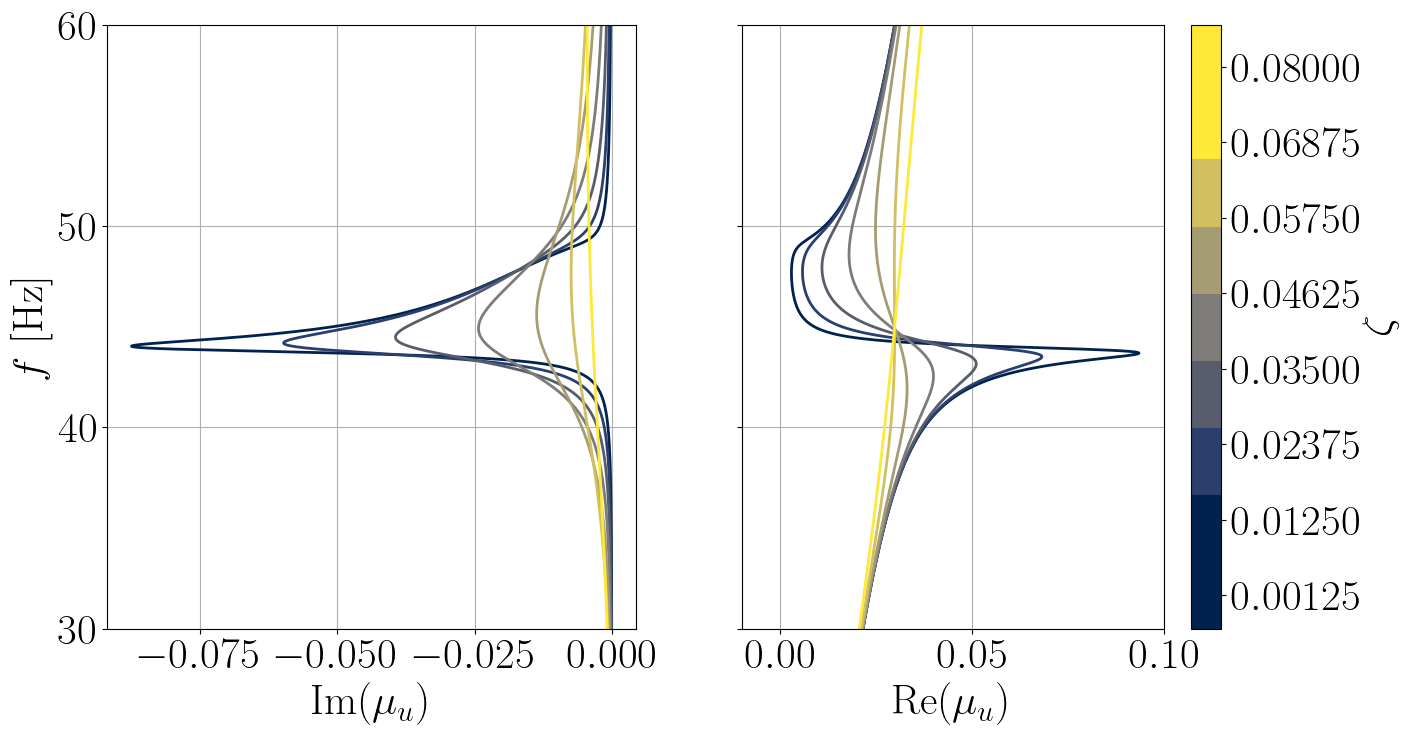

In [46]:
plt.rcParams['figure.figsize'] = [15, 8]

# Color map
N = len(zeta_i)
cmap = plt.get_cmap('cividis',N)
norm = mpl.colors.Normalize(vmin=zeta_i[0],vmax=zeta_i[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

for i in range(len(zeta_i)):
    #Imaginarna os
    ax1.plot(np.imag(mu_u(omega_a, kappa_i[j], alpha_i[j], upsilon_i[j], delta_i[j], eta_i[j], AB, zeta_i[i])), faktor_ups[j]*omega_a, 
             lw=2, color=cmap(i))
    
    #Realna os
    ax2.plot(np.real(mu_u(omega_a, kappa_i[j], alpha_i[j], upsilon_i[j], delta_i[j], eta_i[j], AB, zeta_i[i])), faktor_ups[j]*omega_a, 
             lw=2, color=cmap(i), label= r' $\zeta=$'+ f' {np.round(zeta_i[i],4)}')
    
    
ax1.set_xlabel(r'Im$(\mu_u)$')
ax1.set_ylabel(r'$f$ [Hz]')
ax1.locator_params(axis="x", nbins=4)
ax1.locator_params(axis="y", nbins=5)
#ax1.set_xlim(-0.2, 0)
ax1.set_ylim(30, 60)
ax1.grid()

ax2.set_xlim(-0.01, 0.1)
ax2.set_xlabel(r'Re$(\mu_u)$')
ax2.locator_params(axis="x", nbins=4)
ax2.locator_params(axis="y", nbins=5)
ax2.label_outer()
#ax2.legend(loc= 'upper right')
plt.colorbar(sm, ticks=np.linspace(zeta_i[0], zeta_i[-1], 8), 
             boundaries=np.arange(zeta_i[0]-0.005,zeta_i[-1]+0.0064,.01)
            ).set_label(r'$\zeta$', labelpad=0.5, y=0.5, rotation=90)
ax2.grid()

plt.savefig('FRF_disperzijska_zeta.pdf', format='pdf')
plt.show()

### Disperzijske - prilagoditev ROC ###

ups= 9.770908357078465 del= -35.08363342831386 eta= 105.25090028494158


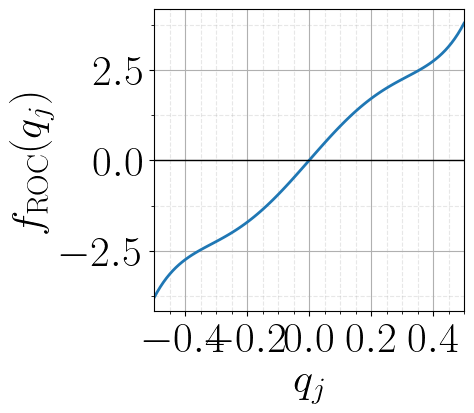

In [170]:
# SPREMENLJIVKE
# amplitude A in B
AB = 0.01
# mase
m = 0.44*10**(-6)# ton
M = 1.72*10**(-6) # ton
beta = m/M
# nelinearna togost k
Ep = 1800
f0 = 750 # Hz
k = 4*np.pi**2*f0**2*m
# linearna togost K
t3 = 0.75 #mm
l3 = 13 #mm
I3 = b*t3**3 / 12 #mm^4
K = 2*(20.372*Ep*I3/l3**3) # togost drugega elementa
alpha = k/K
# dušenje
zeta = 0.01#*np.sqrt(3*beta/(8*(1+beta)**3))
# lastne frekvence
omega_0 = np.sqrt(K/M)
kappa = np.sqrt(alpha/beta)

# aproksimacijska funkcija
gamma = 0.5
mu = 2*gamma/(gamma-1)

upsilon = k
delta = (1-upsilon) / (2*gamma**2*(1-gamma))
eta = -(3*(1-upsilon)) / (8*gamma**4*(1-gamma))

#upsilon = 0.1
#delta = (1-upsilon) / (2*gamma**2*(1-gamma))
#eta = -(3*(1-upsilon)) / (8*gamma**4*(1-gamma))

q_a = np.linspace(-0.5,0.5,100)
f_approx = lambda q, upsilon, delta, eta: upsilon*q + delta*q**3 + eta*q**5

print("ups=", upsilon, "del=", delta, "eta=", eta)
plt.rcParams['figure.figsize'] = [4, 4]
plt.plot(q_a, f_approx(q_a, upsilon, delta, eta), lw=2)
    
plt.xlabel(r'$q_j$')
plt.ylabel(r'$f_\mathrm{ROC}(q_j)$')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=4)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.xlim(-0.5, 0.5)
#plt.ylim(-0.8, 0.8)
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.axhline(0, color='black', lw=1)
plt.show()

In [171]:
#Območje frekvenc
Omega_a = np.linspace(0,1000,100000)

# disperzijske
mu_u = lambda omega, kappa, alpha, upsilon, delta, eta, AB, zeta: np.arccos( 
        ( 2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon) + 4*1j*zeta*kappa*omega - (2+(alpha+kappa**2)*(AB*(3*delta+10*AB*eta)+upsilon))*omega**2 - 2*1j*(1+beta)*zeta*kappa*omega**3+omega**4 ) /
            (2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon)+4*1j*zeta*kappa*omega-2*omega**2)
        )

print('lastna frekvenca resonatorja: ', np.sqrt(k/m) / (2*np.pi))
print('lastna (upsilon) frek. res.: ', np.sqrt(k*upsilon/m) / (2*np.pi))
print()
print('brezdimenzijska resonanca je: ', kappa)
print('brezdimenzijska (upsilon) res.: ',np.sqrt(alpha*upsilon/beta))
print()
print('faktor množenja: ', np.sqrt(k/m) / (2*np.pi) / kappa)
print('faktor (upsilon) množenja: ', np.sqrt(k/m) / (2*np.pi) / np.sqrt(alpha*upsilon/beta))
faktor_ups =  np.sqrt(k/m) / (2*np.pi) / np.sqrt(alpha*upsilon/beta)

lastna frekvenca resonatorja:  750.0
lastna (upsilon) frek. res.:  2344.3839171212203

brezdimenzijska resonanca je:  2.852469646956884
brezdimenzijska (upsilon) res.:  8.916378619202884

faktor množenja:  262.93005459326326
faktor (upsilon) množenja:  84.11486681204318


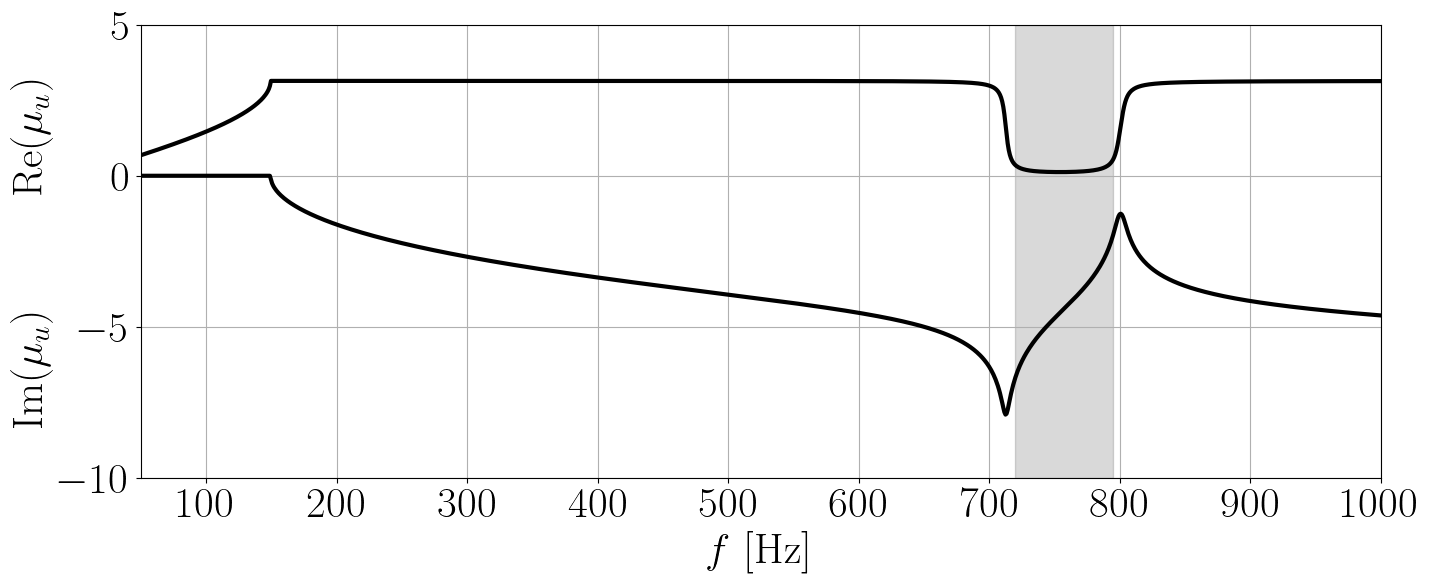

In [173]:
plt.rcParams['figure.figsize'] = [16, 6]

#Realna os
plt.plot(faktor_ups*Omega_a, np.real(mu_u(Omega_a, kappa, alpha, upsilon, delta, eta, AB, zeta)), lw=3, color='black')
#Imaginarna o
plt.plot(faktor_ups*Omega_a, np.imag(mu_u(Omega_a, kappa, alpha, upsilon, delta, eta, AB, zeta)), lw=3, color='black')

plt.axvspan(720,795, alpha=0.15, color='black')



plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=4)
plt.ylim(-10, 5)
plt.xlim(50, 1000)
plt.ylabel(r'Im$(\mu_u) \,\,\,\,\,\,\,\,\,\,\,\,\,\,$ ' + r'     Re$(\mu_u)$')
plt.xlabel(r'$f$ [Hz]')
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=4)
plt.grid()

#plt.tight_layout()
plt.savefig('FRF_disperzijska_popravilo.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Disperzijske članek ###

In [110]:
# SPREMENLJIVKE
# amplitude A in B
AB = 0.01
# mase
m = 0.44*10**(-6)# ton
M = 1.72*10**(-6) # ton
beta = m/M
# togosti
k = 0.8
t3 = 0.75 #mm
l3 = 13 #mm
I3 = b*t3**3 / 12 #mm^4
K = 2*(20.372*Ep*I3/l3**3) # togost drugega elementa
alpha = k/K
# dušenje
zeta = 0.01#*np.sqrt(3*beta/(8*(1+beta)**3))
# lastne frekvence
omega_0 = np.sqrt(K/M)
kappa = np.sqrt(alpha/beta)

# aproksimacijska funkcija
gamma = 0.5
mu = 2*gamma/(gamma-1)
upsilon = k
delta = (1-upsilon) / (2*gamma**2*(1-gamma))
eta = -(3*(1-upsilon)) / (8*gamma**4*(1-gamma))
xsi1=delta
xsi2=eta

# lastne frekvence
kappa = np.sqrt(alpha/beta)
omega_0 = np.sqrt(K/M)

#Območje frekvenc
Omega_a = np.linspace(0,1000,100000)


# disperzijske (članek)
mu_u1 = lambda omega: np.arccos( 
        1 - omega/2 - 1/2 * ( (omega**2*(2*1j*zeta*beta*kappa*omega + alpha*(1+3*xsi1*AB + 10*xsi2*AB**2))) /
                             (-omega**2 + 2*1j*zeta*kappa*omega + kappa**2*(1 + 3*xsi1*AB + 10*xsi2*AB**2)) )
        )
# disperzijska (izpeljava - brez upsilon)
mu_u2 = lambda omega: np.arccos(
    ( ( -(2+alpha+AB*alpha*(3*delta+10*AB*eta))*omega**2+omega**4-(1+AB*(3*delta+10*AB*eta))*kappa**2*(-2+omega**2)-2*1j*zeta*kappa*omega*(-2+(1+beta)*omega**2) ) ) /
    ( (2+2*AB*(3*delta+10*AB*eta))*kappa**2 + 4*1j*zeta*kappa*omega-2*omega**2 )
)
# disperzijska (izpeljava - upsilon)
mu_u3 = lambda omega: np.arccos( 
        ( 2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon) + 4*1j*zeta*kappa*omega - (2+(alpha+kappa**2)*(AB*(3*delta+10*AB*eta)+upsilon))*omega**2 - 2*1j*(1+beta)*zeta*kappa*omega**3+omega**4 ) /
            (2*kappa**2*(AB*(3*delta+10*AB*eta)+upsilon)+4*1j*zeta*kappa*omega-2*omega**2)
        )

In [111]:
print('lastna frekvenca resonatorja: ', np.sqrt(k/m) / (2*np.pi))
print('lastna (upsilon) frek. res.: ', np.sqrt(k*upsilon/m) / (2*np.pi))
print()
print('brezdimenzijska resonanca je: ', kappa)
print('brezdimenzijska (upsilon) res.: ',np.sqrt(alpha*upsilon/beta))
print()
print('faktor množenja: ', np.sqrt(k/m) / (2*np.pi) / kappa)
print('faktor (upsilon) množenja: ', np.sqrt(k/m) / (2*np.pi) / np.sqrt(alpha*upsilon/beta))
faktor = np.sqrt(k/m) / (2*np.pi) / kappa
faktor_ups =  np.sqrt(k/m) / (2*np.pi) / np.sqrt(alpha*upsilon/beta)

lastna frekvenca resonatorja:  214.60448148580193
lastna (upsilon) frek. res.:  191.94808355133927

brezdimenzijska resonanca je:  0.8162036927188941
brezdimenzijska (upsilon) res.:  0.7300347761623189

faktor množenja:  262.93005459326326
faktor (upsilon) množenja:  293.96473769913376


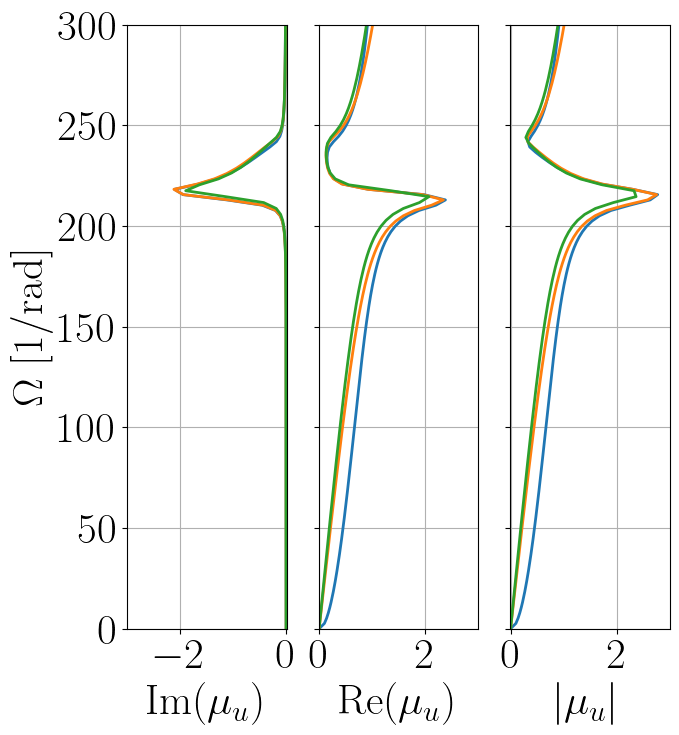

In [112]:
plt.rcParams['figure.figsize'] = [7, 8]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)


#Imaginarna os
ax1.plot(np.imag(mu_u1(Omega_a)), faktor*Omega_a, lw=2)
ax1.plot(np.imag(mu_u2(Omega_a)), faktor*Omega_a, lw=2)
ax1.plot(np.imag(mu_u3(Omega_a)), faktor_ups*Omega_a, lw=2)
    
#Realna os
ax2.plot(np.real(mu_u1(Omega_a)), faktor*Omega_a, lw=2)
ax2.plot(np.real(mu_u2(Omega_a)), faktor*Omega_a, lw=2)
ax2.plot(np.real(mu_u3(Omega_a)), faktor_ups*Omega_a, lw=2)

#Absolutna os
ax3.plot(np.abs(mu_u1(Omega_a)), faktor*Omega_a, lw=2)
ax3.plot(np.abs(mu_u2(Omega_a)), faktor*Omega_a, lw=2)
ax3.plot(np.abs(mu_u3(Omega_a)), faktor_ups*Omega_a, lw=2)
    
    
ax1.set_xlabel(r'Im$(\mu_u)$')
ax1.set_ylabel(r'$\Omega$ [1/rad]')
ax1.locator_params(axis="x", nbins=3)
ax1.locator_params(axis="y", nbins=10)
ax1.set_xlim(-3, 0.01)
ax1.set_ylim(0, 300)
ax1.grid()

ax2.set_xlabel(r'Re$(\mu_u)$')
ax2.locator_params(axis="x", nbins=3)
ax2.locator_params(axis="y", nbins=10)
ax2.set_xlim(-0.01, 3)
ax2.label_outer()
ax2.grid()

ax3.set_xlabel(r'$|\mu_u|$')
ax3.locator_params(axis="x", nbins=3)
ax3.locator_params(axis="y", nbins=10)
ax3.set_xlim(-0.01, 3)
ax3.label_outer()
ax3.grid()

plt.show()

### Disperzijske popravilo (enačba članka) ###

In [179]:
# SPREMENLJIVKE
# amplitude A in B
AB = 0.01
# mase
m = 0.44*10**(-6)# ton
M = 1.72*10**(-6) # ton
beta = m/M
# nelinearna togost k
Ep = 1800
f0 = 750 # Hz
k = 4*np.pi**2*f0**2*m
# linearna togost K
t3 = 0.75 #mm
l3 = 13 #mm
I3 = b*t3**3 / 12 #mm^4
K = 2*(20.372*Ep*I3/l3**3) # togost drugega elementa
alpha = k/K
# dušenje
zeta = 0.01#*np.sqrt(3*beta/(8*(1+beta)**3))
# lastne frekvence
omega_0 = np.sqrt(K/M)
kappa = np.sqrt(alpha/beta)

# aproksimacijska funkcija
xsi1= -4
xsi2= 2

#Območje frekvenc
Omega_a = np.linspace(0,1000,100000)
faktor = np.sqrt(k/m) / (2*np.pi) / kappa

# disperzijske (članek)
mu_u = lambda omega: np.arccos( 
        1 - omega/2 - 1/2 * ( (omega**2*(2*1j*zeta*beta*kappa*omega + alpha*(1+3*xsi1*AB + 10*xsi2*AB**2))) /
                             (-omega**2 + 2*1j*zeta*kappa*omega + kappa**2*(1 + 3*xsi1*AB + 10*xsi2*AB**2)) )
        )

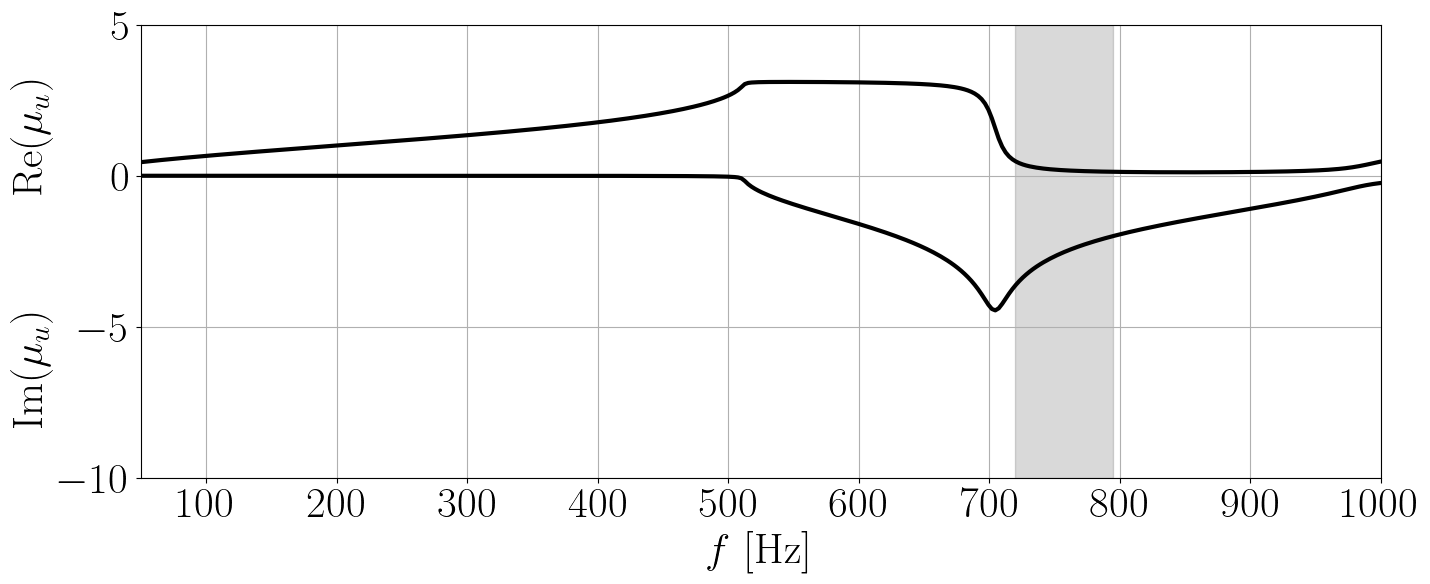

In [183]:
plt.rcParams['figure.figsize'] = [16, 6]

#Realna os
plt.plot(faktor*Omega_a, np.real(mu_u(Omega_a)), lw=3, color='black')
#Imaginarna os
plt.plot(faktor*Omega_a, np.imag(mu_u(Omega_a)), lw=3, color='black')

plt.axvspan(720,795, alpha=0.15, color='black')



plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=4)
plt.ylim(-10, 5)
plt.xlim(50, 1000)
plt.ylabel(r'Im$(\mu_u) \,\,\,\,\,\,\,\,\,\,\,\,\,\,$ ' + r'     Re$(\mu_u)$')
plt.xlabel(r'$f$ [Hz]')
plt.locator_params(axis="x", nbins=10)
plt.locator_params(axis="y", nbins=4)
plt.grid()

#plt.tight_layout()
plt.show()